# Detection of Alzheimer's Disease Using Graph Signal Processing of EEG Recordings


## Data

Link here: https://openneuro.org/datasets/ds004504/versions/1.0.6

### Participants:
- **Total subjects: 88**
  - **Alzheimer's disease (AD group): 36**
    - Average MMSE: 17.75 (sd=4.5)
    - Mean age: 66.4 (sd=7.9)
    - Median disease duration: 25 months, IQR: 24 - 28.5
  - **Frontotemporal Dementia (FTD group): 23**
    - Average MMSE: 22.17 (sd=8.22)
    - Mean age: 63.6 (sd=8.2)
  - **Healthy subjects (CN group): 29**
    - Average MMSE: 30
    - Mean age: 67.9 (sd=5.4)
- **MMSE score ranges:** 0 to 30 (lower scores indicate more severe decline)

### Recordings:
- **Location:** 2nd Department of Neurology of AHEPA General Hospital, Thessaloniki
- **Device:** Nihon Kohden EEG 2100 clinical device, 19 scalp electrodes, 2 reference electrodes
- **Parameters:** 500 Hz sampling rate, 10uV/mm resolution, sensitivity 10uV/mm, time constant 0.3s, high-frequency filter at 70 Hz
- **Duration:** 
  - AD group: 13.5 minutes (min=5.1, max=21.3)
  - FTD group: 12 minutes (min=7.9, max=16.9)
  - CN group: 13.8 minutes (min=12.5, max=16.5)
- **Total recordings:**
  - AD: 485.5 minutes
  - FTD: 276.5 minutes
  - CN: 402 minutes

### Preprocessing:
- **Exported to:** .eeg format, transformed to BIDS accepted .set format
- **Unprocessed recordings in folders named:** sub-0XX
- **Preprocessed and denoised recordings in sub-0XX within subfolder derivatives**
- **Preprocessing pipeline:**
  - Butterworth band-pass filter 0.5-45 Hz
  - Re-referenced to A1-A2
  - Artifact Subspace Reconstruction (ASR) applied
  - Independent Component Analysis (ICA) method performed, transformed to 19 ICA components
  - Eye and jaw artifacts automatically rejected
- **Automatic annotations of artifacts not included for language compatibility**
- **Preprocessed dataset available in Folder:** derivatives

## Methodology

Same as in [Detection of Epilepsy Using Graph Signal Processing of EEG Signals with Three Features](https://link.springer.com/chapter/10.1007/978-981-19-1520-8_46)


## GSP Processing

In [ ]:
import pandas as pd
import numpy as np
import mne
import os
from pygsp import graphs, utils
from scipy.spatial import distance_matrix
from scipy.stats import entropy
import networkx as nx
from sklearn.cluster import spectral_clustering

def compute_total_variation(W, data_values):
    N = data_values.shape[0]
    TV = 0
    for i in range(N):
        for j in range(N):
            wij = W[i, j]
            difference = data_values[j] - data_values[i]
            TV += wij * np.linalg.norm(difference)**2
    return np.sqrt(TV)

dir_path = 'C:\\Users\\Windows\\Desktop\\EEG\\data\\derivatives\\'
file_list = [entry.path for entry in os.scandir(dir_path) if entry.is_file() and entry.path.endswith(".set")]

n_files = len(file_list)
if n_files == 0:
    raise ValueError(f"No .set files found in directory {dir_path}.")

print(f'Found {n_files} .set files.')

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

data_list = []
features = {}

for i, file in enumerate(file_list):
    raw = mne.io.read_raw_eeglab(file)
    data = raw.get_data(picks=channel_names)
    transposed_data = np.transpose(data)
    data = pd.DataFrame(transposed_data, columns=channel_names)
    data = data.groupby(data.index // 50).median()
    data_list.append(data)

    # GSP analysis
    distances = distance_matrix(data.values, data.values)
    theta, k = 1.0, 1.0 
    W = np.exp(-distances**2 / theta**2)
    W[distances > k] = 0
    np.fill_diagonal(W, 0)
    G = graphs.Graph(W)
    L = G.L.toarray()
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    X_GdataT = eigenvectors.T @ data.values
    C = np.cov(X_GdataT)
    T = eigenvectors.T.conj() @ C @ eigenvectors
    r = np.linalg.norm(np.diag(T)) / np.linalg.norm(T, 'fro')
    P = L @ data.values
    Y = np.sum(data.values * P)**2
    TV = compute_total_variation(W, data.values)

    # Spectral Graph Features
    graph_energy = np.sum(np.abs(eigenvalues))
    spectral_entropy = entropy(np.square(eigenvectors))

    # Graph Signal Features
    signal_energy = np.sum(np.square(data.values))
    signal_power = np.var(data.values)

    # Graph Modularity and Community Structure
    labels = spectral_clustering(W)
    unique_labels = len(np.unique(labels))

    # Graph Degree Distribution
    degree_distribution = np.sum(W, axis=0)

    # Graph Diffusion Characteristics
    heat_trace = np.trace(np.exp(-L))
    diffusion_distance = np.sum(np.exp(-L))

    # Aggregating Features
    features[os.path.basename(file)] = {
        'stationary_ratio': r, 
        'Tik-norm': Y, 
        'Total_Variation': TV,
        'graph_energy': graph_energy,
        'spectral_entropy': spectral_entropy,
        'signal_energy': signal_energy,
        'signal_power': signal_power,
        'unique_clusters': unique_labels,
        'avg_degree': np.mean(degree_distribution),
        'heat_trace': heat_trace,
        'diffusion_distance': diffusion_distance
    }

features_data = pd.DataFrame(features).T
features_data.to_csv('features_tv.csv', index_label='participant_id')

## Processing 

In [1]:
import pandas as pd
import numpy as np

features = pd.read_csv("features_tv.csv", )
participants = pd.read_csv("participants.tsv", delimiter='\t')

In [2]:
data = features.merge(participants, left_index=True, right_index=True)
data

,participant_id_x,stationary_ratio,Tik-norm,Total_Variation,graph_energy,spectral_entropy,signal_energy,signal_power,unique_clusters,avg_degree,heat_trace,diffusion_distance,participant_id_y,Gender,Age,Group,MMSE
0,sub-001_task-eyesclosed_eeg.set,0.036979,0.417136,1.136539,3.597000e+07,[8.69918136e+00 5.50501943e-03 1.45696982e-02 ...,0.000108,9.448716e-10,8,5996.999785,0.0,9.777661e+07,sub-001,F,57,A,16
1,sub-002_task-eyesclosed_eeg.set,0.036099,1.152527,1.465304,6.289283e+07,[8.97853441e+00 3.64379040e-03 4.27435644e-03 ...,0.000135,8.982981e-10,8,7929.999729,0.0,1.709604e+08,sub-002,F,78,A,22
2,sub-003_task-eyesclosed_eeg.set,0.048939,0.017792,0.516504,9.366660e+06,[8.02649694 0.00840577 0.01185841 ... 0.607647...,0.000044,7.492876e-10,8,3059.999913,0.0,2.546122e+07,sub-003,M,70,A,14
3,sub-004_task-eyesclosed_eeg.set,0.038817,0.961691,1.400470,4.985066e+07,[8.86234196e+00 4.70419601e-03 7.24164626e-03 ...,0.000139,1.035222e-09,8,7059.999722,0.0,1.355081e+08,sub-004,F,67,A,20
4,sub-005_task-eyesclosed_eeg.set,0.056755,1.528484,1.572462,6.464964e+07,[8.99230873e+00 6.44453204e-03 6.73669735e-03 ...,0.000154,1.006423e-09,8,8039.999692,0.0,1.757359e+08,sub-005,M,70,A,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,sub-084_task-eyesclosed_eeg.set,0.037154,0.357461,1.093509,4.251692e+07,[8.78278302 0.01104814 0.01073822 ... 0.033289...,0.000092,7.400060e-10,8,6519.999817,0.0,1.155730e+08,sub-084,F,71,F,24
84,sub-085_task-eyesclosed_eeg.set,0.060937,0.431738,1.146357,3.136560e+07,[8.63070043e+00 3.92916197e-03 1.31690985e-02 ...,0.000117,1.102371e-09,8,5599.999765,0.0,8.526054e+07,sub-085,M,64,F,26
85,sub-086_task-eyesclosed_eeg.set,0.044006,6.253852,2.236412,3.349515e+07,[8.66354209e+00 5.38151592e-03 6.01591295e-03 ...,0.000434,3.944704e-09,8,5786.999136,0.0,9.104926e+07,sub-086,M,49,F,26
86,sub-087_task-eyesclosed_eeg.set,0.037769,0.503279,1.191152,3.633075e+07,[8.70417056e+00 4.52859990e-03 1.02856205e-02 ...,0.000118,1.027555e-09,8,6026.999765,0.0,9.875723e+07,sub-087,M,73,F,24


## Plotting

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


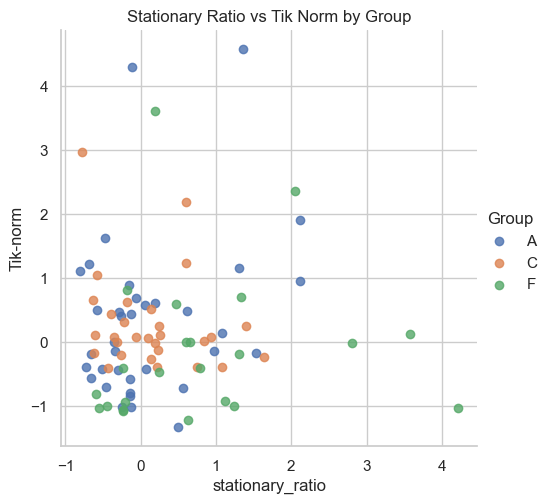

In [3]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Create a robust scaler object
scaler = RobustScaler()

# Fit the scaler to the data and transform it
data[['stationary_ratio', 'Tik-norm']] = scaler.fit_transform(data[['stationary_ratio', 'Tik-norm']])

sns.set(style="whitegrid")

# Use seaborn lmplot function to generate the scatter plot
# Here 'data' is the DataFrame, 'stationary_ratio' and 'Tik_norm' are the x and y variables respectively
# and 'Group' is the category variable used to color the dots
sns.lmplot(data=data, x='stationary_ratio', y='Tik-norm', hue='Group', fit_reg=False, legend=True)

# Set title with matplotlib
plt.title('Stationary Ratio vs Tik Norm by Group')

# Show the plot
plt.show()

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


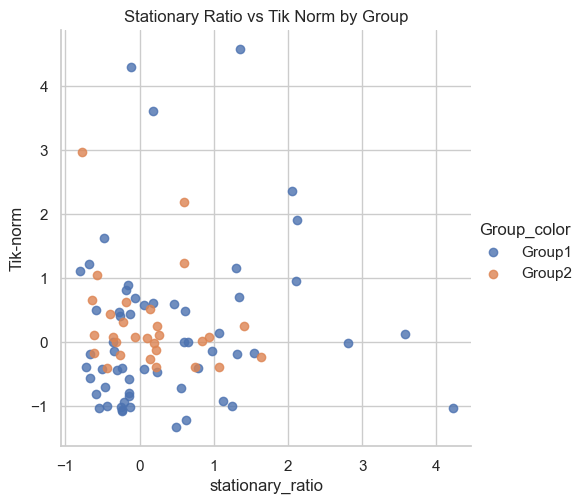

In [4]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column that maps 'A' and 'F' to the same value
data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# Create a robust scaler object
scaler = RobustScaler()

# Fit the scaler to the data and transform it
data[['stationary_ratio', 'Tik-norm']] = scaler.fit_transform(data[['stationary_ratio', 'Tik-norm']])

sns.set(style="whitegrid")

# Use seaborn lmplot function to generate the scatter plot
# Here 'data' is the DataFrame, 'stationary_ratio' and 'Tik_norm' are the x and y variables respectively
# and 'Group_color' is the category variable used to color the dots
sns.lmplot(data=data, x='stationary_ratio', y='Tik-norm', hue='Group_color', fit_reg=False, legend=True)

# Set title with matplotlib
plt.title('Stationary Ratio vs Tik Norm by Group')

# Show the plot
plt.show()

In [5]:
# Print the frequency of each group
group_frequencies = data['Group'].value_counts()
print(group_frequencies)


Group
A    36
C    29
F    23
Name: count, dtype: int64


C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


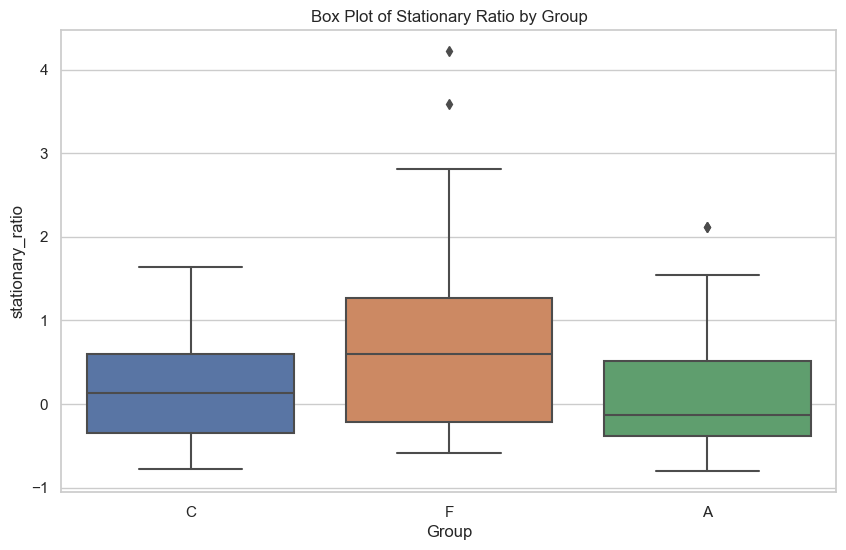

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


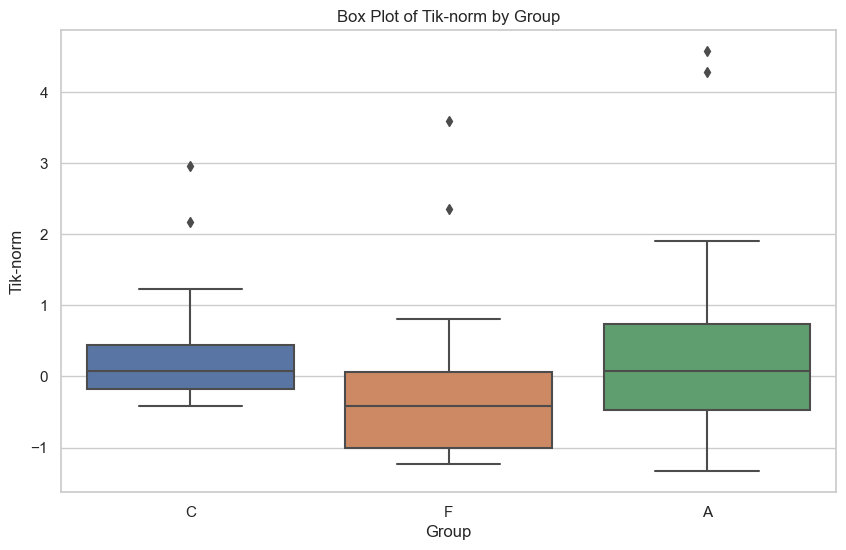

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


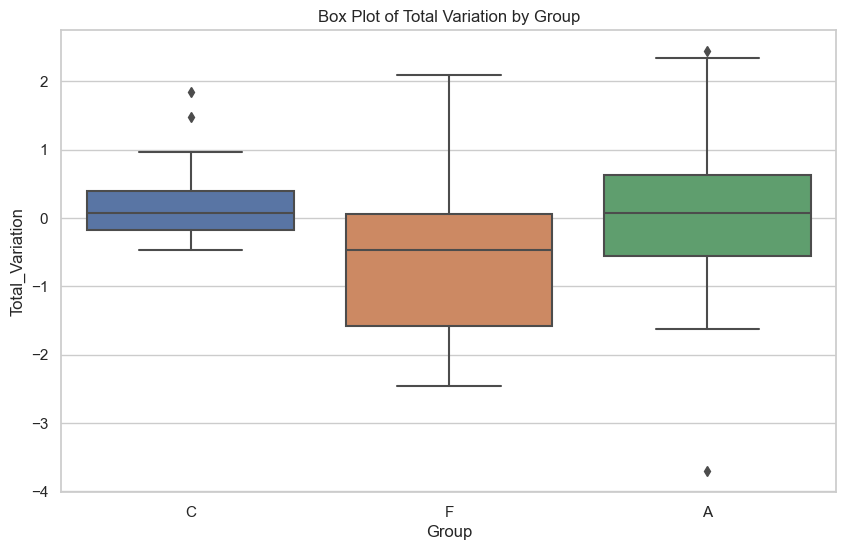

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


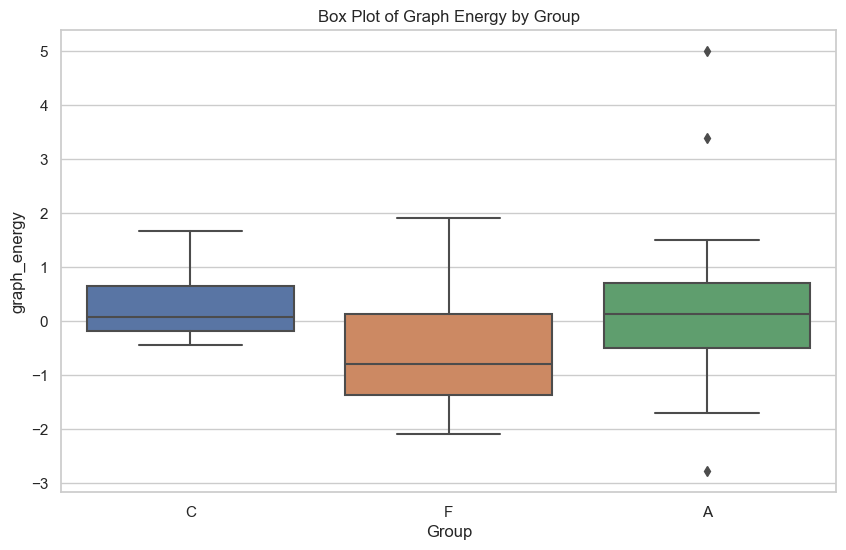

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


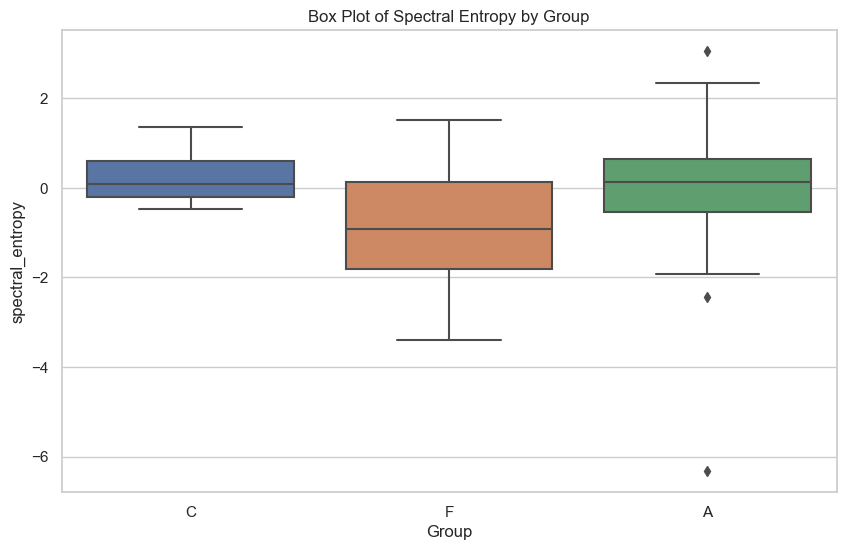

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


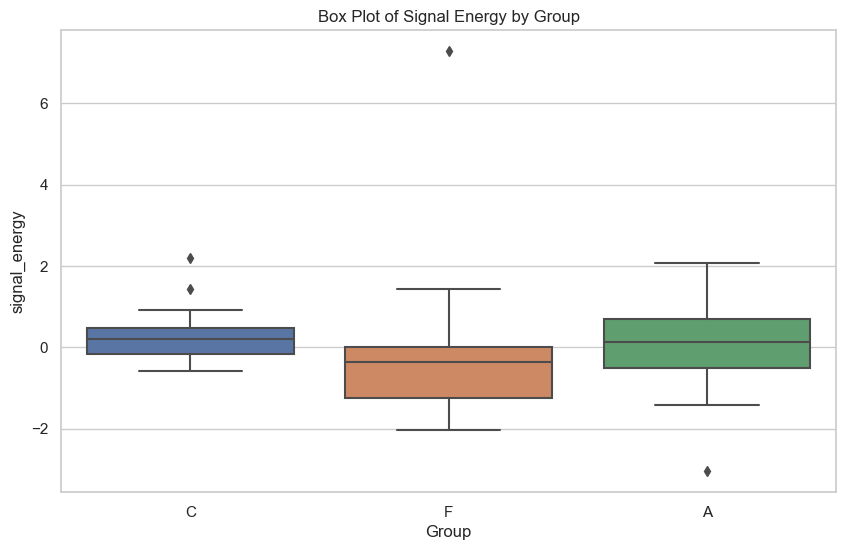

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


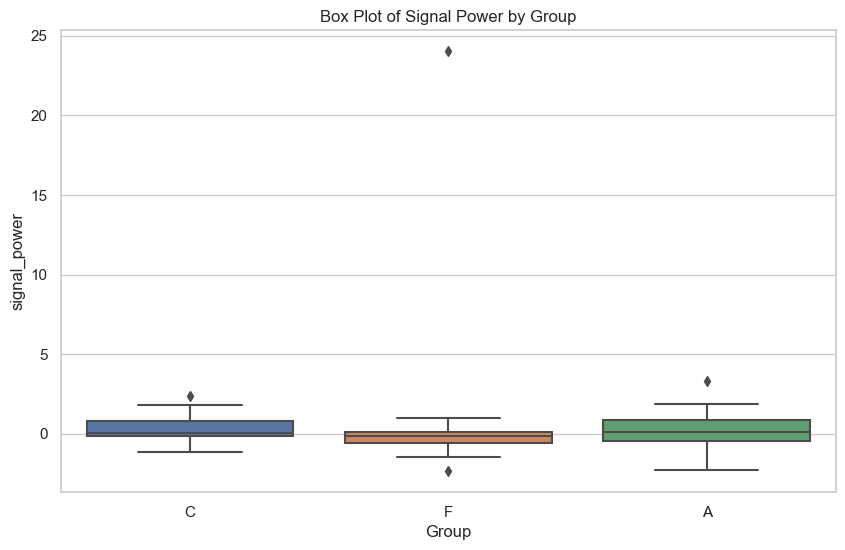

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


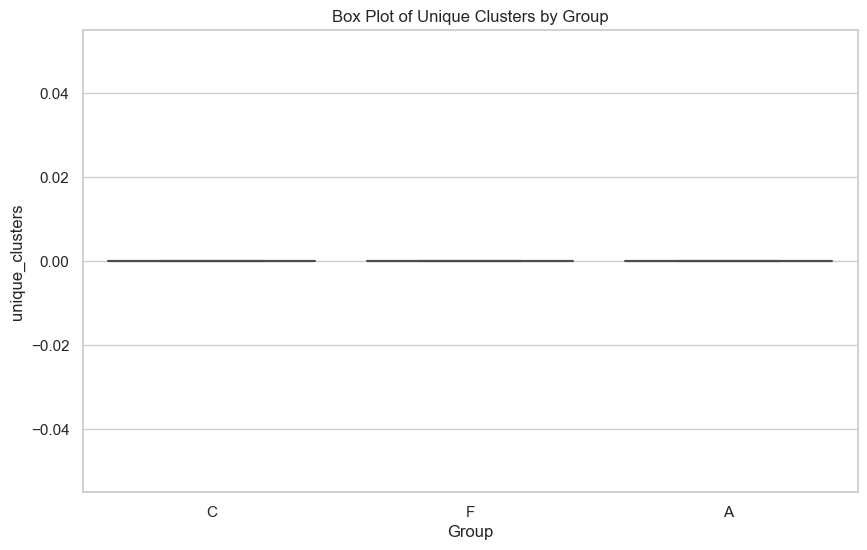

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


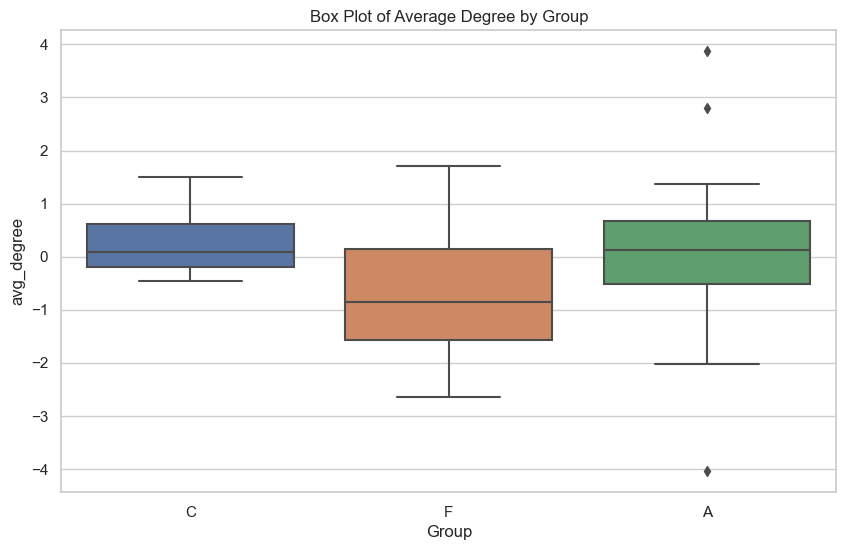

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


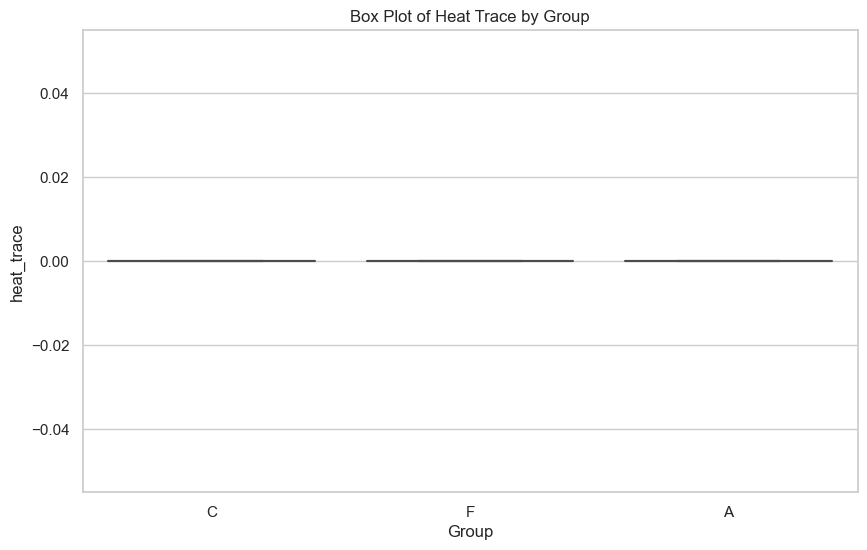

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


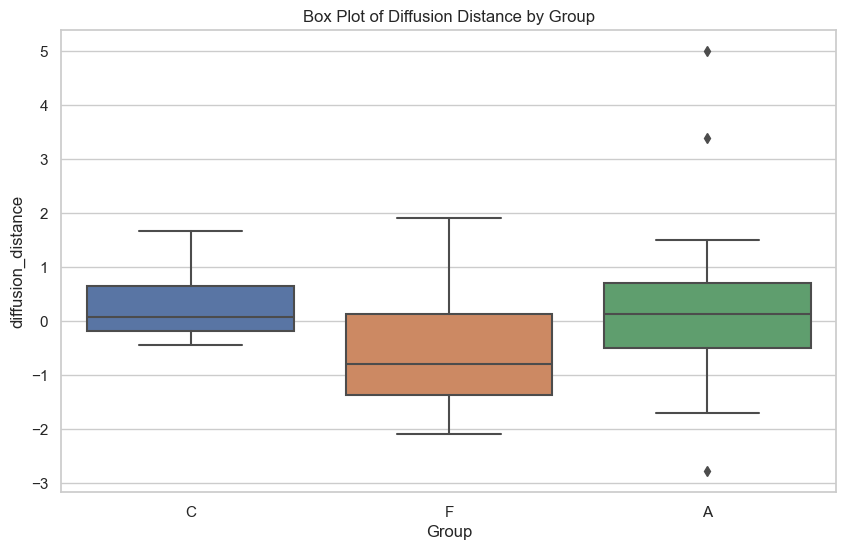

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


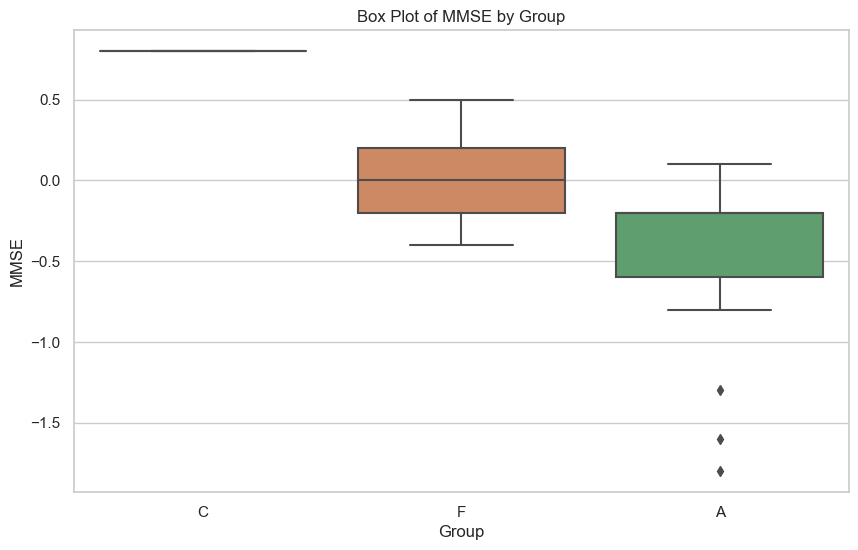

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


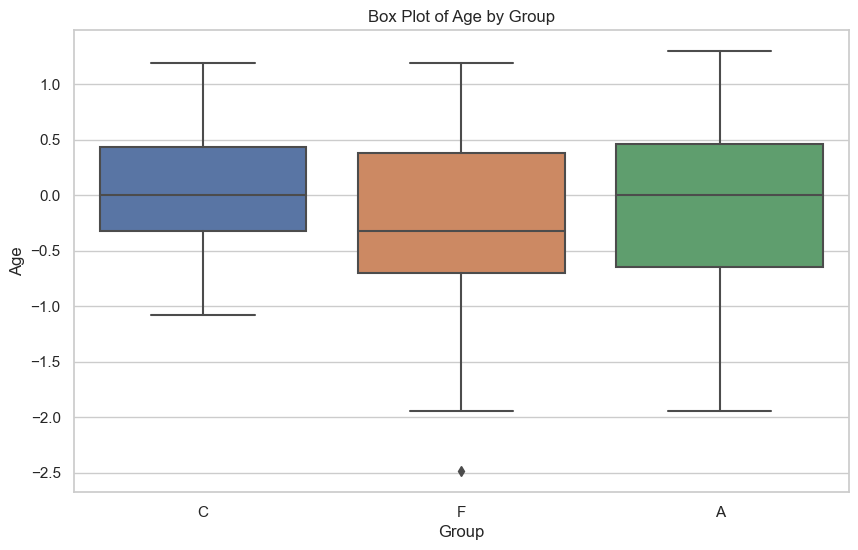

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Assuming 'data' is a DataFrame that contains the columns 'Group' and the features we want to plot
columns_to_scale = ['stationary_ratio', 'Tik-norm', 'Total_Variation', 'graph_energy', 'spectral_entropy', 'signal_energy', 'signal_power', 'unique_clusters', 'avg_degree', 'heat_trace', 'diffusion_distance', 'MMSE', 'Age']

# Detect problematic columns (i.e., columns that contain strings which look like lists)
problematic_columns = [col for col in columns_to_scale if isinstance(data[col].iloc[0], str)]

# Convert those columns
for col in problematic_columns:
    # Modify the string to have commas and then convert to list
    data[col] = data[col].apply(lambda x: eval('[' + ','.join(x.strip('[]').split()) + ']')[0] if isinstance(x, str) else x)

# Create a robust scaler object
scaler = RobustScaler()

# Scale all columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

features_to_plot = {
    'stationary_ratio': 'Stationary Ratio',
    'Tik-norm': 'Tik-norm',
    'Total_Variation': 'Total Variation',
    'graph_energy': 'Graph Energy',
    'spectral_entropy': 'Spectral Entropy',
    'signal_energy': 'Signal Energy',
    'signal_power': 'Signal Power',
    'unique_clusters': 'Unique Clusters',
    'avg_degree': 'Average Degree',
    'heat_trace': 'Heat Trace',
    'diffusion_distance': 'Diffusion Distance',
    'MMSE': 'MMSE',
    'Age': 'Age'
}

group_order = ['C', 'F', 'A']

for feature, title in features_to_plot.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Group", y=feature, data=data, order=group_order)
    plt.title(f'Box Plot of {title} by Group')
    plt.show()


C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Windows\AppData\Local\Programs\Python\P

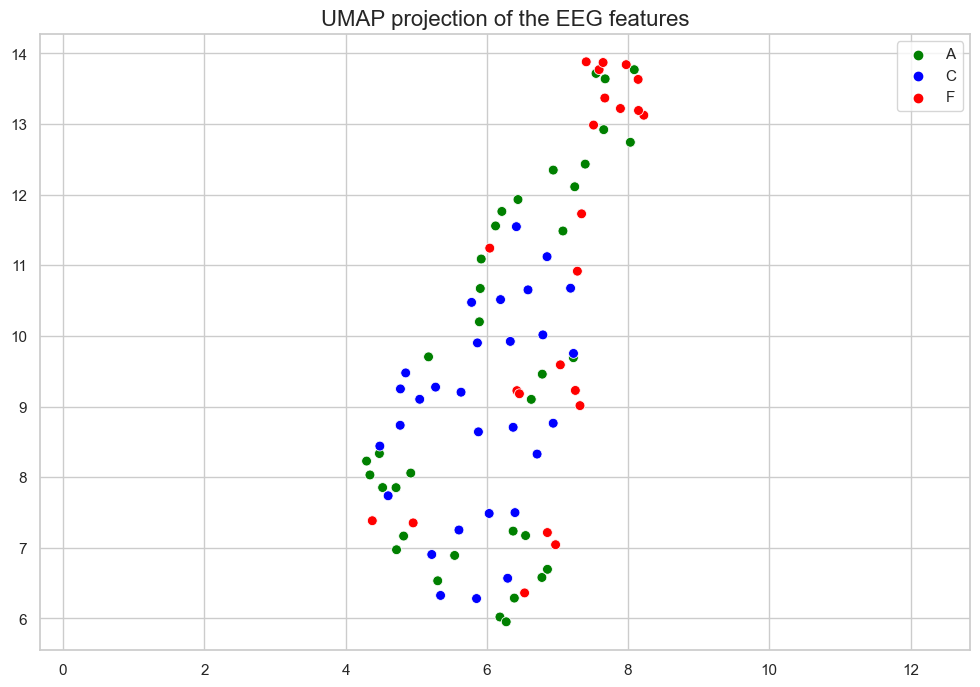

In [7]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the columns you want from the data DataFrame

features = {
    'stationary_ratio': 'Stationary Ratio',
    'Tik-norm': 'Tik-norm',
    'Total_Variation': 'Total Variation',
    'graph_energy': 'Graph Energy',
    'spectral_entropy': 'Spectral Entropy',
    'signal_energy': 'Signal Energy',
    'signal_power': 'Signal Power',
    'avg_degree': 'Average Degree',
    'diffusion_distance': 'Diffusion Distance',
}

selected_data = data[list(features.keys())]

# Create the UMAP object and fit_transform the data to get a 2D representation
reducer = umap.UMAP()
embedding = reducer.fit_transform(selected_data)

# Define a custom color palette
color_palette = {"C": "blue", "F": "red", "A": "green"}

# Plot the UMAP representation
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=data['Group'],
    palette=color_palette, 
    s=50  # Increased size
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the EEG features', fontsize=16)
plt.legend(loc="upper right")
plt.show()


## Multi-Classification

In [8]:
features = {
    'stationary_ratio': 'Stationary Ratio',
    'Tik-norm': 'Tik-norm',
    'Total_Variation': 'Total Variation',
    'graph_energy': 'Graph Energy',
    'spectral_entropy': 'Spectral Entropy',
    'signal_energy': 'Signal Energy',
    'signal_power': 'Signal Power',
    'avg_degree': 'Average Degree',
    'diffusion_distance': 'Diffusion Distance',
}

### KNeighborsClassifier

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# The features are 'stationary_ratio' and 'Tik_norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

# Hyperparameters
params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'canberra']
}

clf = KNeighborsClassifier(n_jobs=-1)
grid_search = GridSearchCV(clf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_int)

best_clf = grid_search.best_estimator_

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = best_clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = best_clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(best_clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(best_clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.5318181818181817
Test ROC AUC for class A (Class 0): 0.5384615384615385
Validation ROC AUC for class C (Class 1): 0.6153846153846154
Test ROC AUC for class C (Class 1): 0.5271739130434783
Validation ROC AUC for class F (Class 2): 0.6726190476190476
Test ROC AUC for class F (Class 2): 0.6705882352941177

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.45      0.82      0.58        11
           C       0.55      0.46      0.50        13
           F       0.00      0.00      0.00         7

    accuracy                           0.48        31
   macro avg       0.33      0.43      0.36        31
weighted avg       0.39      0.48      0.42        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.50      0.54      0.52        13
           C       0.09      0.25      0.13         4
           F       1.00      0

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Random Forest

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# The features are 'stationary_ratio' and 'Tik_norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

# Hyperparameters
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(clf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_int)

best_clf = grid_search.best_estimator_

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = best_clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = best_clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(best_clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(best_clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.5045454545454546
Test ROC AUC for class A (Class 0): 0.4835164835164835
Validation ROC AUC for class C (Class 1): 0.6623931623931624
Test ROC AUC for class C (Class 1): 0.7065217391304348
Validation ROC AUC for class F (Class 2): 0.6904761904761905
Test ROC AUC for class F (Class 2): 0.7941176470588236

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.33      0.55      0.41        11
           C       0.46      0.46      0.46        13
           F       0.00      0.00      0.00         7

    accuracy                           0.39        31
   macro avg       0.26      0.34      0.29        31
weighted avg       0.31      0.39      0.34        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.40      0.46      0.43        13
           C       0.25      0.75      0.38         4
           F       0.00      0

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### XGBoost

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# The features are 'stationary_ratio' and 'Tik_norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

# Hyperparameters
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

clf = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search = GridSearchCV(clf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_int)

best_clf = grid_search.best_estimator_

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = best_clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = best_clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(best_clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(best_clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.6272727272727272
Test ROC AUC for class A (Class 0): 0.46703296703296704
Validation ROC AUC for class C (Class 1): 0.6111111111111112
Test ROC AUC for class C (Class 1): 0.7934782608695652
Validation ROC AUC for class F (Class 2): 0.6547619047619048
Test ROC AUC for class F (Class 2): 0.6823529411764706

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.44      0.36      0.40        11
           C       0.50      0.54      0.52        13
           F       0.38      0.43      0.40         7

    accuracy                           0.45        31
   macro avg       0.44      0.44      0.44        31
weighted avg       0.45      0.45      0.45        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.44      0.31      0.36        13
           C       0.25      0.75      0.38         4
           F       0.67      

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

clf = LogisticRegression(random_state=42, multi_class='auto', solver='liblinear', n_jobs=-1)
clf.fit(X_train_scaled, y_train_int)

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.6454545454545454
Test ROC AUC for class A (Class 0): 0.6043956043956045
Validation ROC AUC for class C (Class 1): 0.641025641025641
Test ROC AUC for class C (Class 1): 0.6956521739130435
Validation ROC AUC for class F (Class 2): 0.8571428571428571
Test ROC AUC for class F (Class 2): 0.6941176470588235

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.57      0.36      0.44        11
           C       0.59      1.00      0.74        13
           F       0.50      0.14      0.22         7

    accuracy                           0.58        31
   macro avg       0.55      0.50      0.47        31
weighted avg       0.56      0.58      0.52        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.67      0.31      0.42        13
           C       0.24      1.00      0.38         4
           F       0.75      0.

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(


### SVM

In [13]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

clf = SVC(probability=True, kernel='linear', random_state=42) # You can change the kernel as needed
clf.fit(X_train_scaled, y_train_int)

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.4409090909090909
Test ROC AUC for class A (Class 0): 0.4340659340659341
Validation ROC AUC for class C (Class 1): 0.44017094017094016
Test ROC AUC for class C (Class 1): 0.5760869565217391
Validation ROC AUC for class F (Class 2): 0.5714285714285715
Test ROC AUC for class F (Class 2): 0.4823529411764706

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.57      0.36      0.44        11
           C       0.59      1.00      0.74        13
           F       0.50      0.14      0.22         7

    accuracy                           0.58        31
   macro avg       0.55      0.50      0.47        31
weighted avg       0.56      0.58      0.52        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.60      0.23      0.33        13
           C       0.21      1.00      0.35         4
           F       1.00      

### Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

clf = GaussianNB()
clf.fit(X_train_scaled, y_train_int)

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))


Validation ROC AUC for class A (Class 0): 0.6181818181818182
Test ROC AUC for class A (Class 0): 0.5631868131868132
Validation ROC AUC for class C (Class 1): 0.7008547008547008
Test ROC AUC for class C (Class 1): 0.9239130434782609
Validation ROC AUC for class F (Class 2): 0.7559523809523809
Test ROC AUC for class F (Class 2): 0.6941176470588236

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.50      0.09      0.15        11
           C       0.55      0.92      0.69        13
           F       0.57      0.57      0.57         7

    accuracy                           0.55        31
   macro avg       0.54      0.53      0.47        31
weighted avg       0.54      0.55      0.47        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.50      0.15      0.24        13
           C       0.27      1.00      0.42         4
           F       0.75      0

### TabTransformer

In [15]:
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import pytorch_tabular
from pytorch_tabular.models.tab_transformer import TabTransformerConfig
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig

# Assuming you've loaded your data and created the 'Group_color' column...

# Extracting features
X = data[list(features.keys())]

# Target variable
y = data['Group']


# Splitting data 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encoding labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Convert datasets to DataFrames
train_df = pd.concat([X_train, pd.Series(y_train_encoded, name='Group', index=X_train.index)], axis=1)
val_df = pd.concat([X_val, pd.Series(y_val_encoded, name='Group', index=X_val.index)], axis=1)
test_df = pd.concat([X_test, pd.Series(y_test_encoded, name='Group', index=X_test.index)], axis=1)

# Define the configurations for TabTransformer
data_config = DataConfig(
    target=['Group'],
    continuous_cols=list(features.keys()),  # Assuming all features are continuous
    categorical_cols=[]
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Automatically find a suitable learning rate
    batch_size=1024,
    max_epochs=1000,
    gpus=1,
    gradient_clip_val=1,  # Gradient clipping
    early_stopping_patience=200  # Early stopping if validation performance doesn't improve for 5 epochs
)
optimizer_config = OptimizerConfig()

# Define the head configuration for TabTransformer
head_config = {}  # Use default configurations for the LinearHead

# Improved TabTransformer Configuration
model_config = TabTransformerConfig(
    task="classification",
    head="LinearHead",
    head_config=head_config,
    num_heads=16,
    num_attn_blocks=16,
    transformer_head_dim=256,
    share_embedding=True,
    share_embedding_strategy='fraction',
    shared_embedding_fraction=0.5,
    attn_dropout=0.2,
    add_norm_dropout=0.2,
    ff_dropout=0.2,
    embedding_dropout=0.2,
    batch_norm_continuous_input=True
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

# Train the model using train_df and val_df
tabular_model.fit(train=train_df, validation=val_df)

time.sleep(3) 

# Evaluate on test set using test_df
test_metrics = tabular_model.evaluate(test_df)
print("Test Metrics for TabTransformer Model on Test Set:", test_metrics)

# Evaluate on validation set using val_df
val_metrics = tabular_model.evaluate(val_df)
print("Test Metrics for TabTransformer Model on Validation Set:", val_metrics)

# Getting predictions on the test dataset
test_predictions = tabular_model.predict(test_df)

# Getting predictions on the validation dataset
val_predictions = tabular_model.predict(val_df)

# Extracting the predicted values for test
test_predicted_values = test_predictions['prediction'].values

# Extracting the predicted values for validation
val_predicted_values = val_predictions['prediction'].values

# Calculate metrics for both test and validation
def calculate_metrics(y_true, predicted_values):
    accuracy = accuracy_score(y_true, predicted_values)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, predicted_values, average='weighted')

    if len(np.unique(y_true)) > 2:  # Multi-class case
        y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
        predicted_values_binarized = label_binarize(predicted_values, classes=np.unique(predicted_values))
        roc_auc = roc_auc_score(y_true_binarized, predicted_values_binarized, average="weighted", multi_class="ovr")
    else:  # Binary case
        roc_auc = roc_auc_score(y_true, predicted_values)
    
    return accuracy, precision, recall, fscore, roc_auc

test_accuracy, test_precision, test_recall, test_fscore, test_roc_auc = calculate_metrics(y_test_encoded, test_predicted_values)
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

val_accuracy, val_precision, val_recall, val_fscore, val_roc_auc = calculate_metrics(y_val_encoded, val_predicted_values)
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_fscore:.4f}")
print(f"ROC-AUC: {val_roc_auc:.4f}")

# Classification Report for Test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test_encoded, test_predicted_values))

# Classification Report for Validation set
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_encoded, val_predicted_values))


2023-08-31 09:32:51,801 - {pytorch_tabular.tabular_model:105} - INFO - Experiment Tracking is turned off

Global seed set to 42


2023-08-31 09:32:51,818 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders

2023-08-31 09:32:51,821 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for          
classification task

2023-08-31 09:32:51,831 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: TabTransformerModel

2023-08-31 09:32:52,036 - {pytorch_tabular.tabular_model:268} - INFO - Preparing the Trainer

C:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2023-08-31 09:32:52,139 - {pytorch_tabular.tabular_model:573} - INFO - Auto LR Find Started

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at C:\Users\Windows\Desktop\EEG\.lr_find_ddaf83ea-3407-4e76-9528-46e3d1cbce34.ckpt
Restored all states from the checkpoint file at C:\Users\Windows\Desktop\EEG\.lr_find_ddaf83ea-3407-4e76-9528-46e3d1cbce34.ckpt


2023-08-31 09:32:54,857 - {pytorch_tabular.tabular_model:575} - INFO - Suggested LR: 0.13182567385564073. For plot 
and detailed analysis, use `find_learning_rate` method.

2023-08-31 09:32:54,860 - {pytorch_tabular.tabular_model:582} - INFO - Training Started

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  1.2 M │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     30 │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.2142857164144516     │
│         test_loss         │    1.2680500745773315     │
└───────────────────────────┴───────────────────────────┘

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5384615659713745     │
│         test_loss         │    1.6332156658172607     │
└───────────────────────────┴───────────────────────────┘

Test Metrics for TabTransformer Model on Test Set: [{'test_loss': 1.2680500745773315, 'test_accuracy': 0.2142857164144516}]


Output()

Test Metrics for TabTransformer Model on Validation Set: [{'test_loss': 1.6332156658172607, 'test_accuracy': 0.5384615659713745}]


Output()


Test Metrics:
Accuracy: 0.2143
Precision: 0.3482
Recall: 0.2143
F1-score: 0.2139
ROC-AUC: 0.4540

Validation Metrics:
Accuracy: 0.5385
Precision: 0.6117
Recall: 0.5385
F1-score: 0.5194
ROC-AUC: 0.6730

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.12      1.00      0.22         1
           2       0.50      0.17      0.25         6

    accuracy                           0.21        14
   macro avg       0.29      0.44      0.22        14
weighted avg       0.35      0.21      0.21        14


Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.43      1.00      0.60         3
           2       0.67      0.50      0.57         4

    accuracy                           0.54        13
   macro avg       0.59      0.61      0.54        13
weighted av

## Binary Classification

In [16]:
features = {
    'stationary_ratio': 'Stationary Ratio',
    'Tik-norm': 'Tik-norm',
    'Total_Variation': 'Total Variation',
    'graph_energy': 'Graph Energy',
    'spectral_entropy': 'Spectral Entropy',
    'signal_energy': 'Signal Energy',
    'signal_power': 'Signal Power',
    'avg_degree': 'Average Degree',
    'diffusion_distance': 'Diffusion Distance',
}

### KNeighborsClassifier

In [17]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import pandas as pd
import numpy as np

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# Extracting features
X = data[list(features.keys())]

# Target variable
y = data['Group_color']

# Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

# Scaling the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Grid search for KNeighborsClassifier
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'canberra']
}
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, cv=5, verbose=2)
grid_knn.fit(X_train_scaled, y_train)

# Using the best model to predict
y_val_pred = grid_knn.best_estimator_.predict(X_val_scaled)
y_val_pred_proba = grid_knn.best_estimator_.predict_proba(X_val_scaled)[:, 1]

# Encoding labels
le = LabelEncoder()
y_val_encoded = le.fit_transform(y_val)

# Validation set metrics
print("Validation Metrics for Best KNeighborsClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val_encoded, y_val_pred_proba))

# Test set metrics
y_test_pred = grid_knn.best_estimator_.predict(X_test_scaled)
y_test_pred_proba = grid_knn.best_estimator_.predict_proba(X_test_scaled)[:, 1]
y_test_encoded = le.transform(y_test)

print("\nTest Metrics for Best KNeighborsClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_test_pred_proba))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Validation Metrics for Best KNeighborsClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.59      0.72      0.65        18
      Group2       0.44      0.31      0.36        13

    accuracy                           0.55        31
   macro avg       0.52      0.51      0.51        31
weighted avg       0.53      0.55      0.53        31

ROC AUC Score: 0.5811965811965811

Test Metrics for Best KNeighborsClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.89      0.74      0.81        23
      Group2       0.25      0.50      0.33         4

    accuracy                           0.70        27
   macro avg       0.57      0.62      0.57        27
weighted avg       0.80      0.70      0.74        27

ROC AUC Score: 0.7826086956521738


### RandomForest

In [18]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import pandas as pd
import numpy as np

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# Extracting features
X = data[list(features.keys())]

# Target variable
y = data['Group_color']

# Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

# Scaling the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Grid search for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, scoring='roc_auc', n_jobs=-1, cv=5, verbose=2)
grid_rf.fit(X_train_scaled, y_train)

# Using the best model to predict
y_val_pred = grid_rf.best_estimator_.predict(X_val_scaled)
y_val_pred_proba = grid_rf.best_estimator_.predict_proba(X_val_scaled)[:, 1]

# Encoding labels
le = LabelEncoder()
y_val_encoded = le.fit_transform(y_val)

# Validation set metrics
print("Validation Metrics for Best RandomForestClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val_encoded, y_val_pred_proba))

# Test set metrics
y_test_pred = grid_rf.best_estimator_.predict(X_test_scaled)
y_test_pred_proba = grid_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]
y_test_encoded = le.transform(y_test)

print("\nTest Metrics for Best RandomForestClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_test_pred_proba))


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Validation Metrics for Best RandomForestClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.58      0.61      0.59        18
      Group2       0.42      0.38      0.40        13

    accuracy                           0.52        31
   macro avg       0.50      0.50      0.50        31
weighted avg       0.51      0.52      0.51        31

ROC AUC Score: 0.46794871794871795

Test Metrics for Best RandomForestClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.94      0.65      0.77        23
      Group2       0.27      0.75      0.40         4

    accuracy                           0.67        27
   macro avg       0.61      0.70      0.58        27
weighted avg       0.84      0.67      0.71        27

ROC AUC Score: 0.7282608695652174


### XGBoost

In [19]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# Extracting features
X = data[list(features.keys())]

# Target variable
y = data['Group_color']

# Encode labels to 0 and 1
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

# Scaling the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Grid search for XGBClassifier
param_grid_xgb = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 500, 1000],
    'max_depth': [3, 5, 7, 10, 15],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

grid_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid_xgb, scoring='roc_auc', n_jobs=-1, cv=5, verbose=2)
grid_xgb.fit(X_train_scaled, y_train)

# Using the best model to predict
y_val_pred = grid_xgb.best_estimator_.predict(X_val_scaled)
y_val_pred_proba = grid_xgb.best_estimator_.predict_proba(X_val_scaled)[:, 1]

# Validation set metrics
print("Validation Metrics for Best XGBClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_pred_proba))

# Test set metrics
y_test_pred = grid_xgb.best_estimator_.predict(X_test_scaled)
y_test_pred_proba = grid_xgb.best_estimator_.predict_proba(X_test_scaled)[:, 1]

print("\nTest Metrics for Best XGBClassifier Model:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_pred_proba))


Fitting 5 folds for each of 14400 candidates, totalling 72000 fits
Validation Metrics for Best XGBClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.56      0.38      0.45        13

    accuracy                           0.61        31
   macro avg       0.60      0.58      0.58        31
weighted avg       0.60      0.61      0.60        31

ROC AUC Score: 0.5128205128205128

Test Metrics for Best XGBClassifier Model:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83        23
           1       0.33      0.75      0.46         4

    accuracy                           0.74        27
   macro avg       0.64      0.74      0.65        27
weighted avg       0.85      0.74      0.77        27

ROC AUC Score: 0.7065217391304348


### Logistic Regression

In [20]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())] # Make sure the column names are correct

# The target is 'Group_color'
y = data['Group_color']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(random_state=42) # You can add hyperparameters as needed

clf.fit(X_train_scaled, y_train)

# Predict the labels of the validation set
y_val_pred = clf.predict(X_val_scaled)

# Predict the probabilities of the validation set
y_val_pred_proba = clf.predict_proba(X_val_scaled)[:, 1]

# Encode labels to 0 and 1
le = LabelEncoder()
y_val_encoded = le.fit_transform(y_val)

# Print the accuracy and other metrics of the classifier on the validation set
print("Validation Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val_encoded, y_val_pred_proba))

# Predict the labels of the test set
y_test_pred = clf.predict(X_test_scaled)

# Predict the probabilities of the test set
y_test_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Encode labels to 0 and 1
y_test_encoded = le.transform(y_test)

# Print the accuracy and other metrics of the classifier on the test set
print("\nTest Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_test_pred_proba))

Validation Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.58      0.78      0.67        18
      Group2       0.43      0.23      0.30        13

    accuracy                           0.55        31
   macro avg       0.51      0.50      0.48        31
weighted avg       0.52      0.55      0.51        31

ROC AUC Score: 0.6495726495726496

Test Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.81      0.74      0.77        23
      Group2       0.00      0.00      0.00         4

    accuracy                           0.63        27
   macro avg       0.40      0.37      0.39        27
weighted avg       0.69      0.63      0.66        27

ROC AUC Score: 0.6195652173913044


### SVM

In [21]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())] # Make sure the column names are correct

# The target is 'Group_color'
y = data['Group_color']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

clf = SVC(random_state=42, probability=True) # You can add hyperparameters as needed

clf.fit(X_train_scaled, y_train)

# Predict the labels of the validation set
y_val_pred = clf.predict(X_val_scaled)

# Predict the probabilities of the validation set
y_val_pred_proba = clf.predict_proba(X_val_scaled)[:, 1]

# Encode labels to 0 and 1
le = LabelEncoder()
y_val_encoded = le.fit_transform(y_val)

# Print the accuracy and other metrics of the classifier on the validation set
print("Validation Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val_encoded, y_val_pred_proba))

# Predict the labels of the test set
y_test_pred = clf.predict(X_test_scaled)

# Predict the probabilities of the test set
y_test_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Encode labels to 0 and 1
y_test_encoded = le.transform(y_test)

# Print the accuracy and other metrics of the classifier on the test set
print("\nTest Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_test_pred_proba))


Validation Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.58      1.00      0.73        18
      Group2       0.00      0.00      0.00        13

    accuracy                           0.58        31
   macro avg       0.29      0.50      0.37        31
weighted avg       0.34      0.58      0.43        31

ROC AUC Score: 0.4358974358974359

Test Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.85      1.00      0.92        23
      Group2       0.00      0.00      0.00         4

    accuracy                           0.85        27
   macro avg       0.43      0.50      0.46        27
weighted avg       0.73      0.85      0.78        27

ROC AUC Score: 0.42391304347826086


### Naive Bayes

In [22]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

data['Group_color'] = data['Group'].map({'A': 'Group1', 'F': 'Group1', 'C': 'Group2'})

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())] # Make sure the column names are correct

# The target is 'Group_color'
y = data['Group_color']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

clf = GaussianNB() # Naive Bayes classifier

clf.fit(X_train_scaled, y_train)

# Predict the labels of the validation set
y_val_pred = clf.predict(X_val_scaled)

# Predict the probabilities of the validation set
y_val_pred_proba = clf.predict_proba(X_val_scaled)[:, 1]

# Encode labels to 0 and 1
le = LabelEncoder()
y_val_encoded = le.fit_transform(y_val)

# Print the accuracy and other metrics of the classifier on the validation set
print("Validation Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val_encoded, y_val_pred_proba))

# Predict the labels of the test set
y_test_pred = clf.predict(X_test_scaled)

# Predict the probabilities of the test set
y_test_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Encode labels to 0 and 1
y_test_encoded = le.transform(y_test)

# Print the accuracy and other metrics of the classifier on the test set
print("\nTest Metrics:")
print("Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test_encoded, y_test_pred_proba))


Validation Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       0.89      0.44      0.59        18
      Group2       0.55      0.92      0.69        13

    accuracy                           0.65        31
   macro avg       0.72      0.68      0.64        31
weighted avg       0.74      0.65      0.63        31

ROC AUC Score: 0.7008547008547009

Test Metrics:
Precision, Recall, F1-score:
               precision    recall  f1-score   support

      Group1       1.00      0.52      0.69        23
      Group2       0.27      1.00      0.42         4

    accuracy                           0.59        27
   macro avg       0.63      0.76      0.55        27
weighted avg       0.89      0.59      0.65        27

ROC AUC Score: 0.9239130434782609


### TabTransformer

In [23]:
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import pytorch_tabular
from pytorch_tabular.models.tab_transformer import TabTransformerConfig
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig

# Assuming you've loaded your data and created the 'Group_color' column...

# Extracting features
X = data[list(features.keys())]
# Target variable
y = data['Group_color']

# Splitting data 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encoding labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Convert datasets to DataFrames
train_df = pd.concat([X_train, pd.Series(y_train_encoded, name='Group_color', index=X_train.index)], axis=1)
val_df = pd.concat([X_val, pd.Series(y_val_encoded, name='Group_color', index=X_val.index)], axis=1)
test_df = pd.concat([X_test, pd.Series(y_test_encoded, name='Group_color', index=X_test.index)], axis=1)

# Define the configurations for TabTransformer
data_config = DataConfig(
    target=['Group_color'],
    continuous_cols=list(features.keys()),  # Assuming all features are continuous
    categorical_cols=[]
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Automatically find a suitable learning rate
    batch_size=1024,
    max_epochs=100_000,
    gpus=1,
    gradient_clip_val=1,  # Gradient clipping
    early_stopping_patience=100  # Early stopping if validation performance doesn't improve for 5 epochs
)
optimizer_config = OptimizerConfig()

# Define the head configuration for TabTransformer
head_config = {}  # Use default configurations for the LinearHead

# Improved TabTransformer Configuration
model_config = TabTransformerConfig(
    task="classification",
    head="LinearHead",
    head_config=head_config,
    num_heads=8,
    num_attn_blocks=8,
    transformer_head_dim=256,
    share_embedding=True,
    share_embedding_strategy='fraction',
    shared_embedding_fraction=0.5,
    attn_dropout=0.2,
    add_norm_dropout=0.2,
    ff_dropout=0.2,
    embedding_dropout=0.2,
    batch_norm_continuous_input=True
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

# Train the model using train_df and val_df
tabular_model.fit(train=train_df, validation=val_df)

time.sleep(3) 

# Evaluate on test set using test_df
test_metrics = tabular_model.evaluate(test_df)
print("Test Metrics for TabTransformer Model on Test Set:", test_metrics)

# Evaluate on validation set using val_df
val_metrics = tabular_model.evaluate(val_df)
print("Test Metrics for TabTransformer Model on Validation Set:", val_metrics)

# Getting predictions on the test dataset
test_predictions = tabular_model.predict(test_df)

# Getting predictions on the validation dataset
val_predictions = tabular_model.predict(val_df)

# Extracting the predicted values for test
test_predicted_values = test_predictions['prediction'].values

# Extracting the predicted values for validation
val_predicted_values = val_predictions['prediction'].values

# Calculate metrics for both test and validation
def calculate_metrics(y_true, predicted_values):
    accuracy = accuracy_score(y_true, predicted_values)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, predicted_values, average='weighted')

    if len(np.unique(y_true)) > 2:  # Multi-class case
        y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
        predicted_values_binarized = label_binarize(predicted_values, classes=np.unique(predicted_values))
        roc_auc = roc_auc_score(y_true_binarized, predicted_values_binarized, average="weighted", multi_class="ovr")
    else:  # Binary case
        roc_auc = roc_auc_score(y_true, predicted_values)
    
    return accuracy, precision, recall, fscore, roc_auc

test_accuracy, test_precision, test_recall, test_fscore, test_roc_auc = calculate_metrics(y_test_encoded, test_predicted_values)
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

val_accuracy, val_precision, val_recall, val_fscore, val_roc_auc = calculate_metrics(y_val_encoded, val_predicted_values)
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_fscore:.4f}")
print(f"ROC-AUC: {val_roc_auc:.4f}")

# Classification Report for Test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test_encoded, test_predicted_values))

# Classification Report for Validation set
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_encoded, val_predicted_values))


2023-08-31 09:35:36,125 - {pytorch_tabular.tabular_model:105} - INFO - Experiment Tracking is turned off

Global seed set to 42


2023-08-31 09:35:36,139 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders

2023-08-31 09:35:36,140 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for          
classification task

2023-08-31 09:35:36,150 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: TabTransformerModel

2023-08-31 09:35:36,169 - {pytorch_tabular.tabular_model:268} - INFO - Preparing the Trainer

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2023-08-31 09:35:36,190 - {pytorch_tabular.tabular_model:573} - INFO - Auto LR Find Started

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at C:\Users\Windows\Desktop\EEG\.lr_find_2c357895-1779-4111-ad5d-21d91db63127.ckpt
Restored all states from the checkpoint file at C:\Users\Windows\Desktop\EEG\.lr_find_2c357895-1779-4111-ad5d-21d91db63127.ckpt


2023-08-31 09:35:37,229 - {pytorch_tabular.tabular_model:575} - INFO - Suggested LR: 0.025118864315095822. For plot
and detailed analysis, use `find_learning_rate` method.

2023-08-31 09:35:37,230 - {pytorch_tabular.tabular_model:582} - INFO - Training Started

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  361 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     20 │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 361 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 361 K                                                                                                
Total estimated model params size (MB): 1

Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2023-08-31 09:35:44,924 - {pytorch_tabular.tabular_model:584} - INFO - Training the model completed

2023-08-31 09:35:44,926 - {pytorch_tabular.tabular_model:1258} - INFO - Loading the best model

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7142857313156128     │
│         test_loss         │    0.4335327446460724     │
└───────────────────────────┴───────────────────────────┘

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7692307829856873     │
│         test_loss         │    0.4934254288673401     │
└───────────────────────────┴───────────────────────────┘

Test Metrics for TabTransformer Model on Test Set: [{'test_loss': 0.4335327446460724, 'test_accuracy': 0.7142857313156128}]


Output()

Test Metrics for TabTransformer Model on Validation Set: [{'test_loss': 0.4934254288673401, 'test_accuracy': 0.7692307829856873}]


Output()


Test Metrics:
Accuracy: 0.7143
Precision: 0.9429
Recall: 0.7143
F1-score: 0.7835
ROC-AUC: 0.8462

Validation Metrics:
Accuracy: 0.7692
Precision: 0.7991
Recall: 0.7692
F1-score: 0.7796
ROC-AUC: 0.7333

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.20      1.00      0.33         1

    accuracy                           0.71        14
   macro avg       0.60      0.85      0.58        14
weighted avg       0.94      0.71      0.78        14


Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.50      0.67      0.57         3

    accuracy                           0.77        13
   macro avg       0.69      0.73      0.71        13
weighted avg       0.80      0.77      0.78        13

